# Feature Selection and Engineering - Beginner's Guide

Learn how feature engineering can help you to up your game when building machine learning models in Kaggle: create new columns, transform variables and more!

In the previous classes, you have already learned about Exploratory Data Analysis (EDA) and building simple machine learning models. In this class, you'll learn more about feature engineering, a process where you use domain knowledge of your data to create additional relevant features that increase the predictive power of the learning algorithm and make your machine learning models perform even better!

More specifically,

- You'll first get started by doing all necessary imports and getting the data in your workspace;
- Then, you'll see some reasons why you should do feature engineering and start working on engineering your own new features for your data set! You'll create new columns, transform variables into numerical ones, handle missing values, and much more.
- Lastly, you'll build a new machine learning model with your new data set and submit it to Kaggle.


# Get Started!

Before you can start off, you're going to do all the imports, just like you did in the previous tutorial, use some IPython magic to make sure the figures are generated inline in the Jupyter Notebook and set the visualization style. Next, you can import your data and make sure that you store the target variable of the training data in a safe place. Afterwards, you merge the train and test data sets (with exception of the `'Survived'` column of `df_train`) and store the result in `data`.

Remember that you do this because you want to make sure that any preprocessing that you do on the data is reflected in both the train and test sets!

Lastly, you use the `.info()` method to take a look at your data:

In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
from sklearn import tree
from sklearn.model_selection import GridSearchCV

In [2]:
# Figures inline and set visualization style
%matplotlib inline
sns.set()
plt.style.use('ggplot')

In [3]:
# Import data
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')

In [4]:
# Store target variable of training data in a safe place
survived_train = df_train.Survived

# Concatenate training and test sets
data = pd.concat([df_train.drop(['Survived'], axis=1), df_test])

# View head
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Name           1309 non-null object
Sex            1309 non-null object
Age            1046 non-null float64
SibSp          1309 non-null int64
Parch          1309 non-null int64
Ticket         1309 non-null object
Fare           1308 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 122.7+ KB


# Why Feature Engineering At All?
You perform feature engineering to extract more information from your data, so that you can up your game when building models.

## Titanic's Passenger Titles
Let's check out what this is all about by looking at an example. Let's check out the `'Name'` column with the help of the `.tail()` method, which helps you to see the last five rows of your data:

In [5]:
# View head of 'Name' column
data.Name.tail()

413              Spector, Mr. Woolf
414    Oliva y Ocana, Dona. Fermina
415    Saether, Mr. Simon Sivertsen
416             Ware, Mr. Frederick
417        Peter, Master. Michael J
Name: Name, dtype: object

Suddenly, you see different titles emerging! In other words, this column contains strings or text that contain titles, such as 'Mr', 'Master' and 'Dona'.

These titles of course give you information on social status, profession, etc., which in the end could tell you something more about survival.

At first sight, it might seem like a difficult task to separate the names from the titles, but don't panic! Remember, you can easily use regular expressions to extract the title and store it in a new column `'Title'`:

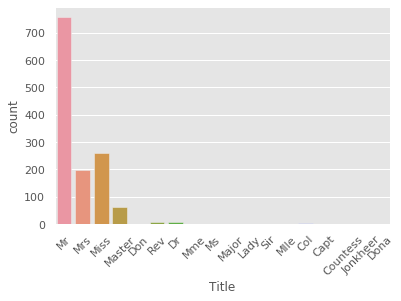

In [6]:
# Extract Title from Name, store in column and plot barplot
data['Title'] = data.Name.apply(lambda x: re.search(' ([A-Z][a-z]+)\.', x).group(1))
sns.countplot(x='Title', data=data);
plt.xticks(rotation=45);

Note that this new column 'Title' is actually a new feature for your data set!

Tip: to learn more about regular expressions, check out my write up of our last [FB Live code along event](https://www.datacamp.com/community/tutorials/web-scraping-python-nlp) or check out DataCamp's [Python Regular Expressions Tutorial](https://www.datacamp.com/community/tutorials/python-regular-expression-tutorial).

You can see that there are several titles in the above plot and there are many that don't occur so often. So, it makes sense to put them in fewer buckets.

For example, you probably want to replace `'Mlle'` and `'Ms'` with `'Miss'` and `'Mme'` by `'Mrs'`, as these are French titles and ideally, you want all your data to be in one language. Next, you also take a bunch of titles that you can't immediately categorize and put them in a bucket called `'Special'`.

Tip: play around with this to see how your algorithm performs as a function of it!

Next, you view a barplot of the result with the help of the `.countplot()` method:

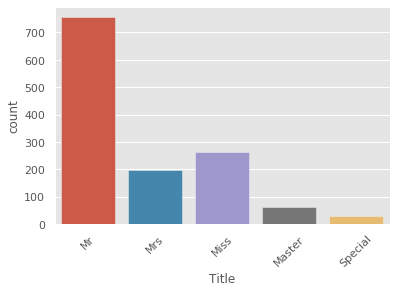

In [7]:
data['Title'] = data['Title'].replace({'Mlle':'Miss', 'Mme':'Mrs', 'Ms':'Miss'})
data['Title'] = data['Title'].replace(['Don', 'Dona', 'Rev', 'Dr',
                                            'Major', 'Lady', 'Sir', 'Col', 'Capt', 'Countess', 'Jonkheer'],'Special')
sns.countplot(x='Title', data=data);
plt.xticks(rotation=45);

This is what your newly engineered feature `'Title'` looks like!

Now, make sure that you have a `'Title'` column and check out your data again with the `.tail()` method:

In [8]:
# View head of data
data.tail()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,Mr
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,Special
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,Mr
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,Mr
417,1309,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C,Master


## Passenger's Cabins
When you loaded in the data and inspected it, you saw that there are several `NaN`s or missing values in the `'Cabin'` column.

It is reasonable to presume that those NaNs didn't have a cabin, which could tell you something about `'Survival'`. So, let's now create a new column `'Has_Cabin'` that encodes this information and tells you whether passengers had a cabin or not.

Note that you use the `.isnull()` method in the code chunk below, which will return `True` if the passenger doesn't have a cabin and `False` if that's not the case. However, since you want to store the result in a column `'Has_Cabin'`, you actually want to flip the result: you want to return `True` if the passenger has a cabin. That's why you use the tilde `~`.

In [9]:
# Did they have a Cabin?
data['Has_Cabin'] = ~data.Cabin.isnull()

# View head of data
data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Has_Cabin
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,False
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,True
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,False
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,True
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,False


What you want to do now is drop a bunch of columns that contain no more useful information (or that we're not sure what to do with). In this case, you're looking at columns such as `['Cabin', 'Name', 'PassengerId', 'Ticket']`, because

- You already extracted information on whether or not the passenger had a cabin in your newly added 'Has_Cabin' column;
- Also, you already extracted the titles from the 'Name' column;
- You also drop the 'PassengerId' and the 'Ticket' columns because these will probably not tell you anything more about the survival of the Titanic passengers.

Tip there might be more information in the 'Cabin' column, but for this tutorial, you assume that there isn't!

To drop these columns in your actual data DataFrame, make sure to use the `inplace` argument in the `.drop()` method and set it to `True`:

In [10]:
# Drop columns and view head
data.drop(['Cabin', 'Name', 'PassengerId', 'Ticket'], axis=1, inplace=True)
data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Has_Cabin
0,3,male,22.0,1,0,7.2500,S,Mr,False
1,1,female,38.0,1,0,71.2833,C,Mrs,True
2,3,female,26.0,0,0,7.9250,S,Miss,False
3,1,female,35.0,1,0,53.1000,S,Mrs,True
4,3,male,35.0,0,0,8.0500,S,Mr,False


Congrats! You've successfully engineered some new features such as `'Title'` and `'Has_Cabin'` and made sure that features that don't add any more useful information for your machine learning model are now dropped from your DataFrame!

Next, you want to deal with deal with missing values, bin your numerical data, and transform all features into numeric variables using `.get_dummies()` again. Lastly, you'll build your final model for this tutorial. Check out how all of this is done in the next sections!

## Handling Missing Values
With all of the changes you have made to your original data DataFrame, it's a good idea to figure out if there are any missing values left with `.info()`:

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 9 columns):
Pclass       1309 non-null int64
Sex          1309 non-null object
Age          1046 non-null float64
SibSp        1309 non-null int64
Parch        1309 non-null int64
Fare         1308 non-null float64
Embarked     1307 non-null object
Title        1309 non-null object
Has_Cabin    1309 non-null bool
dtypes: bool(1), float64(2), int64(3), object(3)
memory usage: 133.3+ KB


The result of the above line of code tells you that you have missing values in `'Age'`, `'Fare'`, and `'Embarked'`.

Remember that you can easily spot this by first looking at the total number of entries (1309) and then checking out the number of non-null values in the columns that `.info()` lists. In this case, you see that `'Age'` has 1046 non-null values, so that means that you have 263 missing values. Similarly, `'Fare'` only has one missing value and 'Embarked' has two missing values.

Just like you did in the previous tutorial, you're going to impute these missing values with the help of `.fillna()`:

Note that, once again, you use the median to fill in the `'Age'` and `'Fare'` columns because it's perfect for dealing with outliers. Other ways to impute missing values would be to use the mean, which you can find by adding all data points and dividing by the number of data points, or mode, which is the number that occurs the highest number of times.

You fill in the two missing values in the `'Embarked'` column with `'S'`, which stands for Southampton, because this value is the most common one out of all the values that you find in this column.

Tip: you can double check this by doing some more Exploratory Data Analysis!

In [12]:
# Impute missing values for Age, Fare, Embarked
data['Age'] = data.Age.fillna(data.Age.median())
data['Fare'] = data.Fare.fillna(data.Fare.median())
data['Embarked'] = data['Embarked'].fillna('S')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 9 columns):
Pclass       1309 non-null int64
Sex          1309 non-null object
Age          1309 non-null float64
SibSp        1309 non-null int64
Parch        1309 non-null int64
Fare         1309 non-null float64
Embarked     1309 non-null object
Title        1309 non-null object
Has_Cabin    1309 non-null bool
dtypes: bool(1), float64(2), int64(3), object(3)
memory usage: 133.3+ KB


In [13]:
data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Has_Cabin
0,3,male,22.0,1,0,7.2500,S,Mr,False
1,1,female,38.0,1,0,71.2833,C,Mrs,True
2,3,female,26.0,0,0,7.9250,S,Miss,False
3,1,female,35.0,1,0,53.1000,S,Mrs,True
4,3,male,35.0,0,0,8.0500,S,Mr,False


## Bin numerical data
Next, you want to bin the numerical data, because you have a range of ages and fares. However, there might be fluctuations in those numbers that don't reflect patterns in the data, which might be noise. That's why you'll put people that are within a certain range of age or fare in the same bin. You can do this by using the `pandas` function `qcut()` to bin your numerical data:

In [14]:
# Binning numerical columns
data['CatAge'] = pd.qcut(data.Age, q=4, labels=False )
data['CatFare']= pd.qcut(data.Fare, q=4, labels=False)
data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Has_Cabin,CatAge,CatFare
0,3,male,22.0,1,0,7.2500,S,Mr,False,0,0
1,1,female,38.0,1,0,71.2833,C,Mrs,True,3,3
2,3,female,26.0,0,0,7.9250,S,Miss,False,1,1
3,1,female,35.0,1,0,53.1000,S,Mrs,True,2,3
4,3,male,35.0,0,0,8.0500,S,Mr,False,2,1


Note that you pass in the data as a Series, `data.Age` and `data.Fare`, after which you specify the number of quantiles, `q=4`. Lastly, you set the `labels` argument to `False` to encode the bins as numbers.

Now that you have all of that information in bins, you can now safely drop `'Age'` and `'Fare'` columns. Don't forget to check out the first five rows of your data!

In [15]:
data = data.drop(['Age', 'Fare'], axis=1)
data.head()

,Pclass,Sex,SibSp,Parch,Embarked,Title,Has_Cabin,CatAge,CatFare
0,3,male,1,0,S,Mr,False,0,0
1,1,female,1,0,C,Mrs,True,3,3
2,3,female,0,0,S,Miss,False,1,1
3,1,female,1,0,S,Mrs,True,2,3
4,3,male,0,0,S,Mr,False,2,1


## Number of Members in Family Onboard
The next thing you can do is create a new column, which is the number of members in families that were onboard of the Titanic. In this tutorial, you won't go in this and see how the model performs without it. If you do want to check out how the model would do with this additional column, run the following line of code:

In [16]:
# Create column of number of Family members onboard
data['Fam_Size'] = data.Parch + data.SibSp

For now, you will just go ahead and drop the `'SibSp'` and `'Parch'` columns from your DataFrame:

In [17]:
# Drop columns
data = data.drop(['SibSp','Parch'], axis=1)
data.head()

,Pclass,Sex,Embarked,Title,Has_Cabin,CatAge,CatFare,Fam_Size
0,3,male,S,Mr,False,0,0,1
1,1,female,C,Mrs,True,3,3,1
2,3,female,S,Miss,False,1,1,0
3,1,female,S,Mrs,True,2,3,1
4,3,male,S,Mr,False,2,1,0


## Have you noticed?

Have you noticed that we have completed several feature engineering steps? From **binning numerical variables** to figure out **number of family members onboard**, these are both feature engineering steps. So essentially, we are creating new features based on existing features - using **background human intelligence** - and then remove the original variable(s). This requires you as an analyst to:

- Understand the dataset, in particular the data dictionary well;
- Understand the business background well.

It is easy said than done - but that would be the goal.

## Transform Variables into Numerical Variables
Now that you have engineered some more features, such as `'Title'` and `'Has_Cabin'`, and you have dealt with missing values, binned your numerical data, it's time to transform all variables into numeric ones. You do this because machine learning models generally take numeric input.

As you have done previously, you will use `.get_dummies()` to do this:

In [18]:
# Transform into binary variables
data_dum = pd.get_dummies(data, drop_first=True)
data_dum.head()

,Pclass,Has_Cabin,CatAge,CatFare,Fam_Size,Sex_male,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Special
0,3,False,0,0,1,1,0,1,0,1,0,0
1,1,True,3,3,1,0,0,0,0,0,1,0
2,3,False,1,1,0,0,0,1,1,0,0,0
3,1,True,2,3,1,0,0,1,0,0,1,0
4,3,False,2,1,0,1,0,1,0,1,0,0


With all of this done, it's time to build your final model!


## Building models with Your New Data Set!
As before, you'll first split your `data` back into training and test sets. Then, you'll transform them into arrays:

In [20]:
# Split into test.train
data_train = data_dum.iloc[:891]
data_test = data_dum.iloc[891:]

# Transform into arrays for scikit-learn
X = data_train.values
test = data_test.values
y = survived_train.values


You're now going to build a decision tree on your brand new feature-engineered dataset. To choose your hyperparameter `max_depth`, you'll use a variation on test train split called **cross validation**.
<img src='http://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1514303215/cv_raxrt7.png' />

You begin by splitting the dataset into `5` groups or folds. Then you hold out the *first* fold as a **test set**, fit your model on the remaining four folds, predict on the test set and compute the metric of interest. Next, you hold out the *second* fold as your **test set**, fit on the remaining data, predict on the test set and compute the metric of interest. Then similarly with the *third*, *fourth* and *fifth*.

**NOTE**: Cross-validation (CV) is an efficient way of avoid overfitting your models - be sure to use it when possible.

As a result, you get five values of accuracy, from which you can compute statistics of interest, such as the median and/or mean and 95% confidence intervals.

You do this for each value of each hyperparameter that you're tuning and choose the set of hyperparameters that performs the best. This is called **grid search**.

Enough about that for now, let's get it!

In the following, you'll use **cross validation** and **grid search** to choose the best `max_depth` for your new feature-engineered dataset:

In [21]:
# Setup the hyperparameter grid
dep = np.arange(1,9)
param_grid = {'max_depth' : dep}

# Instantiate a decision tree classifier: clf
clf = tree.DecisionTreeClassifier()

# Instantiate the GridSearchCV object: clf_cv
clf_cv = GridSearchCV(clf, param_grid=param_grid, cv=5)

# Fit it to the data
clf_cv.fit(X, y)

# Print the tuned parameter and score
print("Tuned Decision Tree Parameters: {}".format(clf_cv.best_params_))
print("Best score is {}".format(clf_cv.best_score_))

Tuned Decision Tree Parameters: {'max_depth': 3}
Best score is 0.8293766869625259


Now, you can make predictions on your test set, create a new column `'Survived'` and store your predictions in it. Don't forget to save the `'PassengerId'` and `'Survived'` columns of `df_test` to a .csv and submit it to Kaggle to look at how good your model is.
The accuracy of your submission is 78.9.